## The mission of this project is to gain a comprehensive understanding of the causes of brain stroke; and second, to develop predictive models that can accurately forecast the likelihood of brain stroke and identify the most significant contributing factors.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Understand data

In [3]:
data = pd.read_csv('brain_stroke.csv')
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


Check if there's any missing dataset

In [ ]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# 2. Data Exploration

<AxesSubplot:>

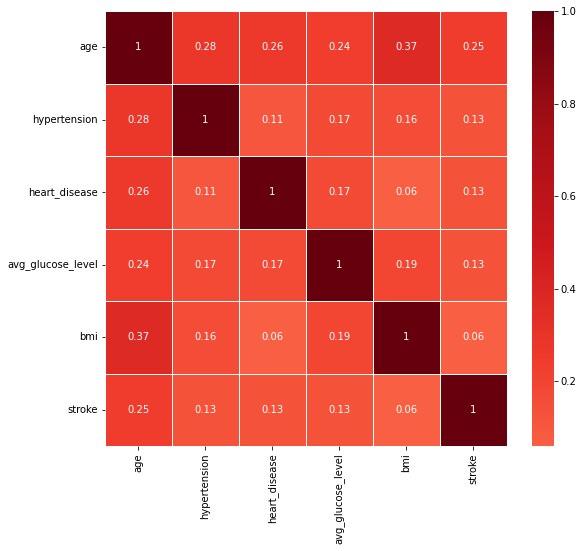

In [ ]:
f,ax = plt.subplots(figsize=(9,8))
sns.heatmap(round(data.corr(),2), center=0, linewidths=0.5, cmap='Reds', annot=True)

<Axes: >

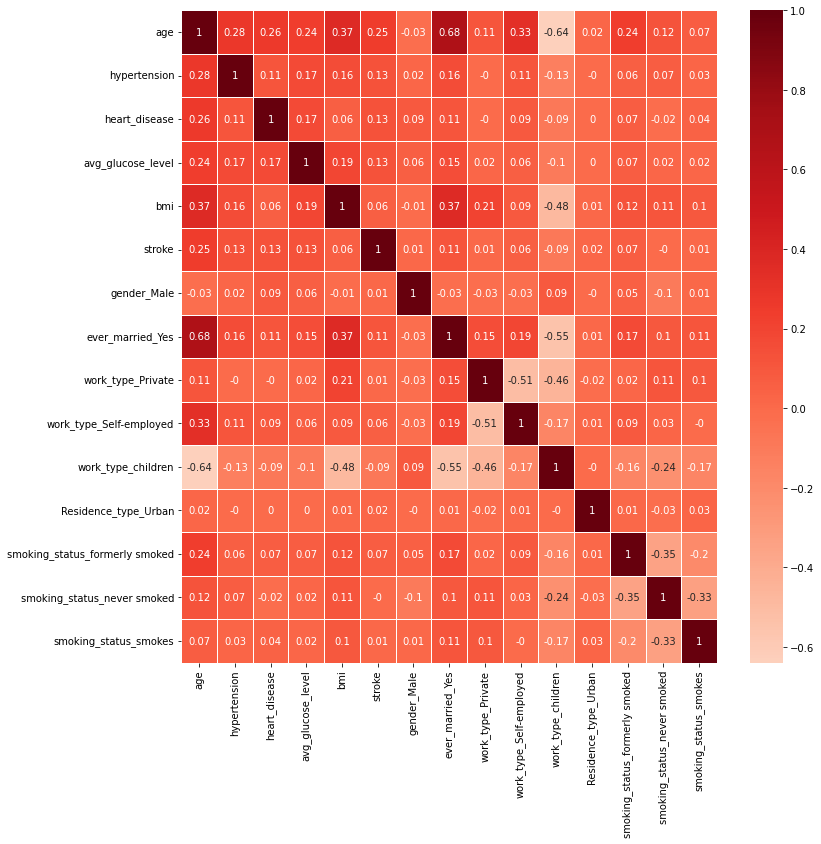

In [4]:
data_dummies = pd.get_dummies(data, drop_first=True)
f,ax = plt.subplots(figsize=(12,12))
sns.heatmap(round(data_dummies.corr(),2), center=0, linewidths=0.5, cmap='Reds', annot=True)

The correlation heatmap above indicates patients' age and marrital status have the highest correlation

## Detecting multicollinearity with Variance Inflation Factor (VIF)

VIF scores tell us BMI and Age are contributing multicollinearity the most

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = data_dummies.columns
vif_data["VIF"] = [variance_inflation_factor(data_dummies.values, i) for i in range(len(data_dummies.columns))]

In [ ]:
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
4,bmi,14.596347
0,age,12.412784
3,avg_glucose_level,7.050178
7,ever_married_Yes,5.808290
8,work_type_Private,4.534785
13,smoking_status_never smoked,2.689602
9,work_type_Self-employed,2.154151
11,Residence_type_Urban,1.998125
10,work_type_children,1.928953
12,smoking_status_formerly smoked,1.913086


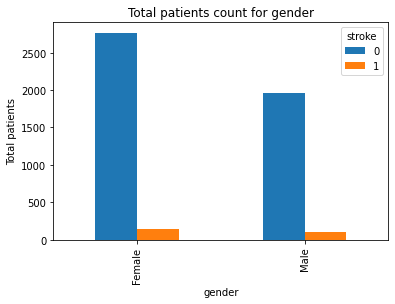

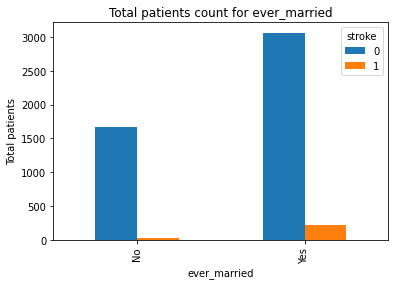

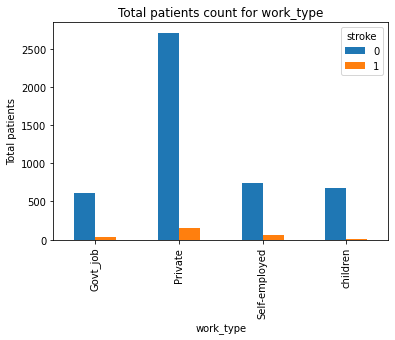

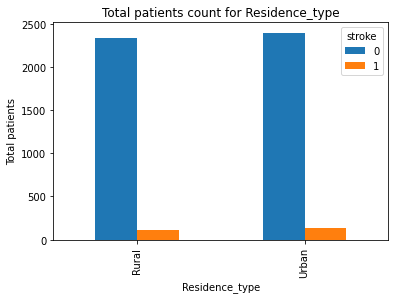

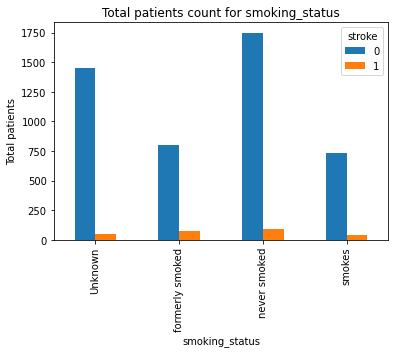

In [59]:
categorical_variables = data.select_dtypes(include= 'object').columns

for column in categorical_variables:
  pd.crosstab(data[column],data.stroke).plot(kind='bar')
  plt.title(f'Total patients count for {column}')
  plt.xlabel(column)
  plt.ylabel('Total patients')

## Stroke patients data visualizations

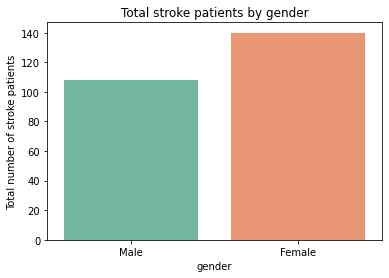

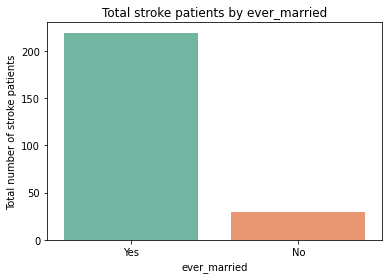

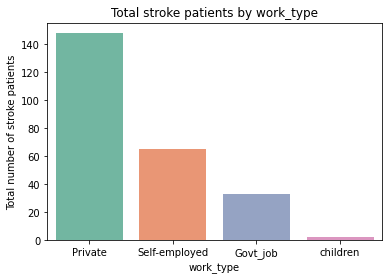

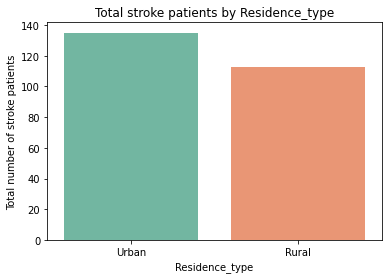

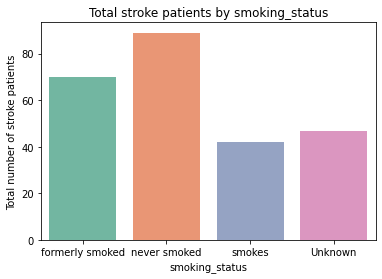

In [5]:
categorical_variables = data.select_dtypes(include= 'object').columns
stroke_patient = data[data['stroke'] == 1]

for column in categorical_variables:
  plot = sns.countplot(x=f'{column}', data=stroke_patient, palette="Set2")
  plot.set_title(f'Total stroke patients by {column}')
  plot.set_ylabel('Total number of stroke patients')
  plt.show()
  

## Chi-square test: See if some categorical variables and brain stroke are independent.

In [5]:
data_dummies = pd.get_dummies(data)

**1. Heart disease**

In [6]:
data.groupby('heart_disease')['stroke'].mean()

heart_disease
0    0.042711
1    0.170909
Name: stroke, dtype: float64

In [7]:
data['heart_disease'].value_counts()

0    4706
1     275
Name: heart_disease, dtype: int64

In [8]:
from scipy.stats import chi2_contingency

chisqt = pd.crosstab(data.heart_disease, data.stroke, margins=True)
print(chisqt)

stroke            0    1   All
heart_disease                 
0              4505  201  4706
1               228   47   275
All            4733  248  4981


Since p-value is significantly smaller than 0.05, we can reject the Null and assume that the variables heart disease and brain stroke are not independent.

In [9]:
value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
print(chi2_contingency(value)[1:3])

(2.519361480046263e-20, 2)


**2. Smoking status**


The p-value for current smokers is greater than 0.05, indicating that their smoking status is not statistically significant in relation to brain stroke. However, for former smokers, the p-value is significant, suggesting that their smoking status is associated with brain stroke. **Thus, we can conclude that smoking status, particularly former smoking status, is not independent of the occurrence of brain stroke.**

In [12]:
chisqt = pd.crosstab(data_dummies['smoking_status_smokes'], data['stroke'], margins=True)
print(chisqt)

value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
print(chi2_contingency(value)[1:3])

stroke                    0    1   All
smoking_status_smokes                 
0                      3999  206  4205
1                       734   42   776
All                    4733  248  4981
(0.8331689603066638, 2)


In [12]:
chisqt = pd.crosstab(data_dummies['smoking_status_formerly smoked'], data['stroke'], margins=True)
print(chisqt)

value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
print(chi2_contingency(value)[1:3])

stroke                             0    1   All
smoking_status_formerly smoked                 
0                               3936  178  4114
1                                797   70   867
All                             4733  248  4981
(2.427114615558574e-05, 2)


**3. Hypertension**

Since p-value is significantly smaller than 0.05, we can reject the Null and assume that the variables hypertension and brain stroke are not independent.

In [13]:
chisqt = pd.crosstab(data_dummies['hypertension'], data['stroke'], margins=True)
print(chisqt)

value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
print(chi2_contingency(value)[1:3])

stroke           0    1   All
hypertension                 
0             4320  182  4502
1              413   66   479
All           4733  248  4981
(1.458625970992074e-19, 2)


## Compare some numerical variables with stroke 

**1. Glucoase**

<Axes: title={'center': 'Average glucose level'}, xlabel='Stroke', ylabel='Average glucose level'>

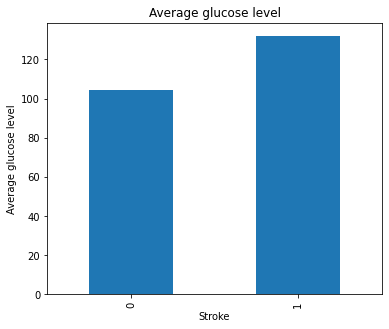

In [24]:
glucose_mean = data.groupby('stroke')['avg_glucose_level'].mean()

glucose_mean.plot(kind='bar', title='Average glucose level', ylabel='Average glucose level',
         xlabel='Stroke', figsize=(6, 5))


**2. Age**

<Axes: title={'center': 'Average age'}, xlabel='Stroke', ylabel='Average age'>

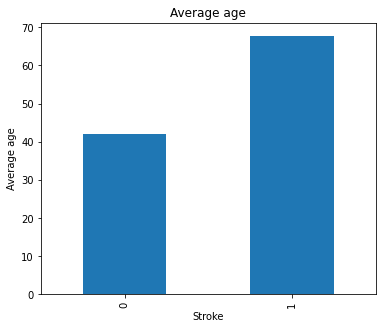

In [23]:
age_mean = data.groupby('stroke')['age'].mean()

age_mean.plot(kind='bar', title='Average age', ylabel='Average age',
         xlabel='Stroke', figsize=(6, 5))

**3. BMI**

<Axes: title={'center': 'Average BMI'}, xlabel='Stroke', ylabel='Average BMI'>

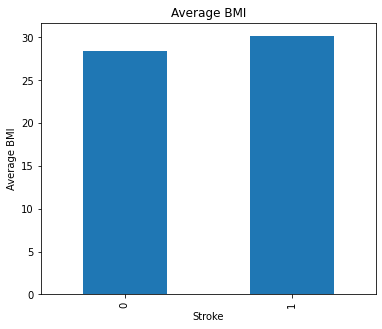

In [22]:
bmi_mean = data.groupby('stroke')['bmi'].mean()

bmi_mean.plot(kind='bar', title='Average BMI', ylabel='Average BMI',
         xlabel='Stroke', figsize=(6, 5))

Let's see if differences in numerical variable between two groups are significant

## Welch's t-test 

All results turns out the difference in numerical variables between the stroke patients and non-stroke are significant.

In [14]:
import scipy.stats as stats

# glucose
print("Glucose level between stroke patients and non-stroke patients")
print(stats.ttest_ind(data[data['stroke']==0]['avg_glucose_level'], data[data['stroke']==1]['avg_glucose_level'], equal_var = False))
print()

# age
print("Age between stroke patients and non-stroke patients")
print(stats.ttest_ind(data[data['stroke']==0]['age'], data[data['stroke']==1]['age'], equal_var = False))
print()

# bmi
print("BMI between stroke patients and non-stroke patients")
print(stats.ttest_ind(data[data['stroke']==0]['bmi'], data[data['stroke']==1]['bmi'], equal_var = False))

Glucose level between stroke patients and non-stroke patients
Ttest_indResult(statistic=-6.94793477846086, pvalue=2.969865335598248e-11)

Age between stroke patients and non-stroke patients
Ttest_indResult(statistic=-29.594885990244755, pvalue=2.5561353987479415e-95)

BMI between stroke patients and non-stroke patients
Ttest_indResult(statistic=-4.766920237851907, pvalue=2.9816641340746633e-06)


# Data Preprocessing

## Encoding

Let's observe all the categorical variables. 

In [15]:
categorical_variables = data.select_dtypes(include= 'object').columns
categorical_variables

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [38]:
data['gender'].value_counts()

Female    2907
Male      2074
Name: gender, dtype: int64

In [39]:
data['ever_married'].value_counts()

Yes    3280
No     1701
Name: ever_married, dtype: int64

In [40]:
data['work_type'].value_counts()

Private          2860
Self-employed     804
children          673
Govt_job          644
Name: work_type, dtype: int64

In [41]:
data['Residence_type'].value_counts()

Urban    2532
Rural    2449
Name: Residence_type, dtype: int64

About 30% of 'smoking_status' data is unknown. Since, it's a huge proportion, I will predict the missing value using **Random Forest classification model**. 

In [42]:
data['smoking_status'].value_counts()

never smoked       1838
Unknown            1500
formerly smoked     867
smokes              776
Name: smoking_status, dtype: int64

As the variables have a low cardinality, we can employ **one-hot encoding**.

In [16]:
from sklearn import preprocessing

# Initializing dictionary
enc = {'never smoked': 0, 'formerly smoked': 1, 'smokes': 2}

# Create dummy variables for all categorical variables except for smoking 
smoking_pred = pd.get_dummies(data, columns = ['gender', 'ever_married', 'work_type', 'Residence_type'], drop_first=True)

smoking_unknown = smoking_pred[smoking_pred['smoking_status'] == 'Unknown']
smoking_notUnknown = smoking_pred[smoking_pred['smoking_status'] != 'Unknown']
smoking_notUnknown['smoking_status'] = smoking_notUnknown['smoking_status'].map(lambda x: enc[x])

X_train = smoking_notUnknown.drop(['smoking_status'], axis=1)
y_train = smoking_notUnknown['smoking_status']

X_pred = smoking_unknown.drop(['smoking_status'], axis=1)

<ipython-input-16-8972c3fca958>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoking_notUnknown['smoking_status'] = smoking_notUnknown['smoking_status'].map(lambda x: enc[x])


Train Random Forest model with train dataset and predict patients with unknown smoking status

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_pred)

Let's see the result

In [18]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2]), array([1178,  223,   99]))

In [19]:
X_pred['smoking_status'] = y_pred
data_processed = pd.concat([smoking_notUnknown, X_pred], ignore_index=True)
data_processed

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban
0,67.00,0,1,228.69,36.6,1,1,1,1,1,0,0,1
1,80.00,0,1,105.92,32.5,0,1,1,1,1,0,0,0
2,49.00,0,0,171.23,34.4,2,1,0,1,1,0,0,1
3,79.00,1,0,174.12,24.0,0,1,0,1,0,1,0,0
4,81.00,0,0,186.21,29.0,1,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,32.00,1,0,74.43,31.5,0,0,1,0,1,0,0,0
4977,3.00,0,0,194.75,20.1,0,0,1,0,0,0,1,0
4978,59.00,0,0,223.16,33.2,1,0,1,1,1,0,0,1
4979,70.00,0,1,65.68,28.6,1,0,0,1,0,1,0,0


## Over-sampling using SMOTE

data is imbalanced

In [20]:
data_processed['stroke'].value_counts()

0    4733
1     248
Name: stroke, dtype: int64

In [121]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(data_processed.drop(['stroke'], axis=1), data_processed['stroke'])


Now the data is balanced

In [22]:
y.value_counts()

1    4733
0    4733
Name: stroke, dtype: int64

# Compare different classification models

## Feature Scaling

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [124]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

## 1) Logistic Regression

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression()

# Train the model on training data
logreg.fit(X_train_scaled, y_train)

log_y_pred = logreg.predict(X_test_scaled)

print(classification_report(y_test, log_y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1430
           1       0.80      0.83      0.82      1410

    accuracy                           0.82      2840
   macro avg       0.82      0.82      0.82      2840
weighted avg       0.82      0.82      0.82      2840



In [126]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)

clf_y_pred = clf.predict(X_test)

print(classification_report(y_test, clf_y_pred))

              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1430
           1       0.72      0.94      0.81      1410

    accuracy                           0.79      2840
   macro avg       0.82      0.79      0.78      2840
weighted avg       0.82      0.79      0.78      2840



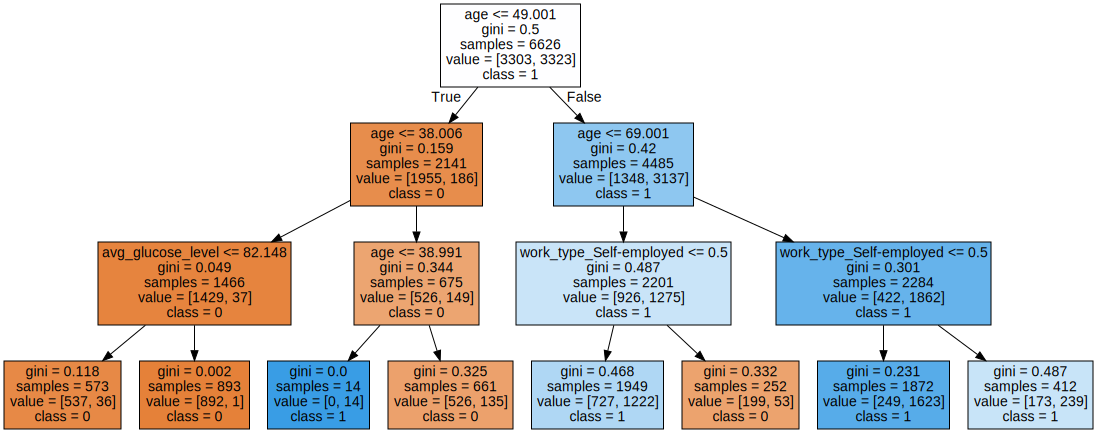

In [127]:
import graphviz

features = data_processed.drop('stroke', axis=1).columns
labels = ['0','1']

# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=features,  
                                class_names=labels,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

## 2) Random Forest

In [129]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1430
           1       0.93      0.95      0.94      1410

    accuracy                           0.94      2840
   macro avg       0.94      0.94      0.94      2840
weighted avg       0.94      0.94      0.94      2840



Text(0.5, 0, 'Feature Importance')

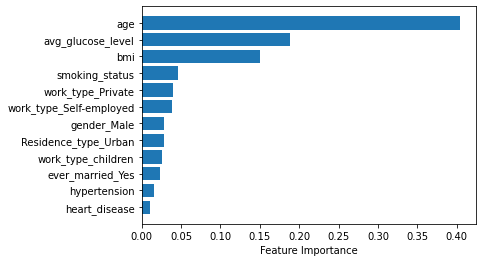

In [130]:
sort = rf.feature_importances_.argsort()
plt.barh(features[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

## 3) Linear Discriminant Analysis (LDA)

In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
lda = lda.fit(X_train, y_train)

print(classification_report(y_test, lda.predict(X_test)))


              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1430
           1       0.80      0.85      0.82      1410

    accuracy                           0.82      2840
   macro avg       0.82      0.82      0.82      2840
weighted avg       0.82      0.82      0.82      2840



In conclusion, Random forest has the best performance on predicting brain stroke with F1 score of 94%.  